In [1]:
%tensorflow_version 1.4

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.4`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.python.lib.io import file_io

import keras
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import confusion_matrix
from seaborn import heatmap

%matplotlib inline

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
print(tf.__version__)
print(keras.__version__)

1.15.2
2.3.1


In [5]:
EPOCHS = 150
BS = 128
DROPOUT_RATE = 0.3
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

In [20]:
model = Sequential()
model.add(BatchNormalization(input_shape=(48,48,1)))
model.add(Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(48,48,1),name="conv1"))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool1"))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu',padding='same',name="conv2"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool2"))         
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',name="conv3"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool3"))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',name="conv4"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool4"))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1024, activation='relu',name='fc1'))
model.add(Dropout(DROPOUT_RATE))
model.add(BatchNormalization())
model.add(Dense(7, activation='softmax',name='fcsoftmax'))

#TODO: weight decay of 0.0001...initial learning rate is set to 0.01 and reduced by a factor of 2 at every 25 epoch
sgd = SGD(lr=SGD_LEARNING_RATE,momentum=0.9, decay=SGD_DECAY, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

# checkpoint
cp_filepath='/content/drive/My Drive/Facial Expression/Facial_Expression/models/soa-SGD_LR_0.01000-EPOCHS_300-BS_128-DROPOUT_0.3test_acc_0.663.h5'
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)
checkpoint = ModelCheckpoint(cp_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [rlrop,checkpoint]

In [21]:
!apt install file
!file '/content/drive/My Drive/Facial Expression/Facial_Expression/train.zip'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
file is already the newest version (1:5.32-2ubuntu0.4).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
/content/drive/My Drive/Facial Expression/Facial_Expression/train.zip: Zip archive data, at least v1.0 to extract


In [22]:
! rm -rf train; mkdir train
! unzip -q '/content/drive/My Drive/Facial Expression/Facial_Expression/train.zip' -d train


In [23]:
! rm -rf dev; mkdir dev
! unzip -q '/content/drive/My Drive/Facial Expression/Facial_Expression/test-public.zip' -d dev
! rm -rf test; mkdir test
! unzip -q '/content/drive/My Drive/Facial Expression/Facial_Expression/test-private.zip' -d test

In [24]:
%%bash
root='/content/train/'
IFS=$(echo -en "\n\b")
(for dir in $(ls -1 "$root")
    do printf "$dir: " && ls -i "$root$dir" | wc -l
 done)

0 angry: 3995
1 disgust: 436
2 fear: 4097
3 happy: 7215
4 sad: 4830
5 surprise: 3171
6 neutral: 4965


In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(48, 48),
            color_mode='grayscale',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [26]:
train_generator  = get_datagen('/content/train', True)
dev_generator    = get_datagen('/content/dev')
test_generator  = get_datagen('/content/test')

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [27]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    #steps_per_epoch=28709// BS,
    #validation_steps=3509 // BS,
    shuffle=True,
    epochs=EPOCHS,
    callbacks=callbacks_list,
#    callbacks=[rlrop],
    use_multiprocessing=False,
)

Epoch 1/150
225/225 [==============================] - 24s 107ms/step - loss: 1.9991 - accuracy: 0.2578 - val_loss: 2.4155 - val_accuracy: 0.2577
Epoch 2/150
  7/225 [..............................] - ETA: 5s - loss: 1.8664 - accuracy: 0.2879

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


225/225 [==============================] - 22s 100ms/step - loss: 1.8059 - accuracy: 0.2966 - val_loss: 1.2146 - val_accuracy: 0.3229
Epoch 3/150
225/225 [==============================] - 23s 101ms/step - loss: 1.7321 - accuracy: 0.3306 - val_loss: 0.9823 - val_accuracy: 0.4177
Epoch 4/150
225/225 [==============================] - 23s 101ms/step - loss: 1.6543 - accuracy: 0.3690 - val_loss: 1.0716 - val_accuracy: 0.4578
Epoch 5/150
225/225 [==============================] - 23s 102ms/step - loss: 1.5810 - accuracy: 0.3947 - val_loss: 1.2526 - val_accuracy: 0.4792
Epoch 6/150
225/225 [==============================] - 23s 101ms/step - loss: 1.5277 - accuracy: 0.4199 - val_loss: 2.0598 - val_accuracy: 0.4843
Epoch 7/150
225/225 [==============================] - 23s 102ms/step - loss: 1.4769 - accuracy: 0.4377 - val_loss: 1.4134 - val_accuracy: 0.4901
Epoch 8/150
225/225 [==============================] - 23s 100ms/step - loss: 1.4389 - accuracy: 0.4533 - val_loss: 1.8562 - val_accurac

In [28]:
print('\n# Evaluate on dev data')
results_dev = model.evaluate_generator(dev_generator, 3509 // BS)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data
dev loss, dev acc: [1.1036826372146606, 0.6539351940155029]


In [29]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(test_generator, 3509 // BS)
print('test loss, test acc:', results_test)


# Evaluate on test data
test loss, test acc: [0.7564399242401123, 0.6692708134651184]


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


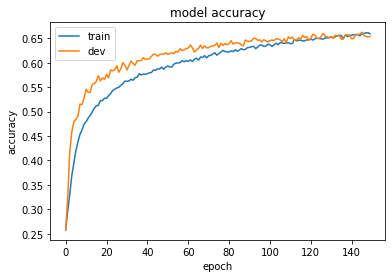

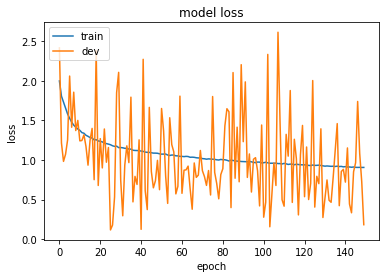

In [30]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [31]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [32]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
dropout_str = '-DROPOUT_' + str(DROPOUT_RATE)
test_acc = '-test_acc_%.3f' % results_test[1]
model.save('/content/drive/My Drive/Facial Expression/Facial_Expression/models/' + 'SOA' + epoch_str + dropout_str + test_acc + '.h5')

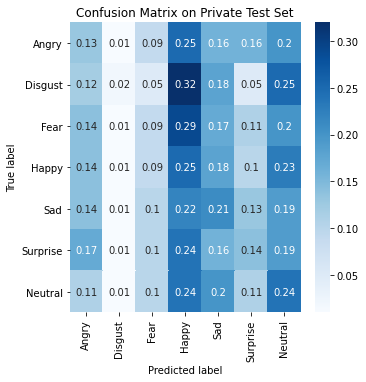

In [33]:
emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

y_pred = model.predict_generator(dev_generator).argmax(axis=1)
y_true = dev_generator.classes

cmat_df_test=pd.DataFrame(
  confusion_matrix(y_true, y_pred, normalize='true').round(2),
  index=emotions.values(), 
  columns=emotions.values()
  )

plt.figure(figsize=(5,5))
heatmap(cmat_df_test,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix on Private Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [34]:
from sklearn.metrics import accuracy_score
# configure image data augmentation
datagen = ImageDataGenerator(horizontal_flip=True)

# make a prediction using test-time augmentation
def tta_prediction(datagen, model, image, n_examples):
	# convert image into dataset
	samples = np.expand_dims(image, 0)
	# prepare iterator
	it = datagen.flow(samples, batch_size=n_examples)
	# make predictions for each augmented image
	yhats = model.predict_generator(it, steps=n_examples, verbose=0)
	# sum across predictions
	summed = np.sum(yhats, axis=0)
	# argmax across classes
	return np.argmax(summed)
 
 # evaluate a model on a dataset using test-time augmentation
def tta_evaluate_model(model, testX, testY):
	# configure image data augmentation
	datagen = ImageDataGenerator(horizontal_flip=True)
	# define the number of augmented images to generate per test set image
	n_examples_per_image = 7
	yhats = list()
	for i in range(len(testX)):
		# make augmented prediction
		yhat = tta_prediction(datagen, model, testX[i], n_examples_per_image)
		# store for evaluation
		yhats.append(yhat)
	# calculate accuracy
	testY_labels = np.argmax(testY, axis=1)
	acc = accuracy_score(testY_labels, yhats)
	return acc

In [36]:
print('\n# Evaluate on test data')
#TTA_results_test = tta_evaluate_model(model, X_test, Y_test)
print('test loss, test acc:', results_test)
print('TTA test acc:', TTA_results_test)


# Evaluate on test data
test loss, test acc: [0.7564399242401123, 0.6692708134651184]


NameError: ignored